# Text Classifier
Notebook demonstrates training of Bidirectional LSTM model for text classification. In this notebook we do data preprocessing, model training and validation on test dataset.
## 1. Preprocessing and EDA
During the preprocessing step we can choose the how we would like to preprocess our data. I considered 1) leaving data as is, 2) lemmatizing it or 3) stemming it. With experimentation I found that lemmatizing data does a good job or reducing the size of models vocabulary (and therefore model size), while not effecting models performance too much.
Also an important hyper-parameter is maximal sequence length of out model. To derive it I examined the distribution of text length in the dataset. We see that 80% of data has less then 100 tokens (see output below). 
Number of samples per class is imbalanced, negatives are more present. It may negatively effect the model's ability to generalize if prior probability of one class is higher then others. Also imbalanced learning requires more careful validation. There are many ways to address this issue, but for simplicity I will under-sample the overrepresented class. 
See the execution below. It produces some basic EDA and resampling information. After the below script is completed we will have train and test splits vectorized and ready for training / testing.

Note: To run preprocessing script you need to make sure all required nltk components are downloaded (see README)


In [62]:
!python process.py --strategy UnderSample --method lemm_v --max_seq_len 110

2022-11-25 19:17:12,378 models       INFO     Performing Basic EDA...
2022-11-25 19:17:12,380 models       INFO     -- Number of Samples:
2022-11-25 19:17:12,380 models       INFO     	Total: 12610
2022-11-25 19:17:12,380 models       INFO     	Positives: 4749
2022-11-25 19:17:12,380 models       INFO     	negatives: 7861

2022-11-25 19:17:12,739 models       INFO     -- Sequence Lengths:
2022-11-25 19:17:12,739 models       INFO     	Max Sequence Length: 218619
2022-11-25 19:17:12,739 models       INFO     	Min Sequence Length: 0
2022-11-25 19:17:12,740 models       INFO     	Seq. Length Percentiles:
2022-11-25 19:17:12,740 models       INFO     		 15-th percentile = 16.0
2022-11-25 19:17:12,741 models       INFO     		 25-th percentile = 21.0
2022-11-25 19:17:12,741 models       INFO     		 50-th percentile = 40.0
2022-11-25 19:17:12,742 models       INFO     		 75-th percentile = 79.75
2022-11-25 19:17:12,743 models       INFO     		 80-th percentile = 94.0
2022-11-25 19:17:12,743 m

Vectorized datasets can be loaded with numpy.

In [32]:
import numpy as np
import json

train = np.load('data/train.npz')
test = np.load('data/test.npz')

#shapes of vectorized training set
train['X'].shape, train['y'].shape


((7598, 110), (7598,))

## 2 Seq. model and Training

Script below will train and save BiLSTM model.

In [33]:
!python train.py --model_path 'data/model/' --num_epochs 3 --max_seq_len 110


2022-11-25 18:49:50,143 models       INFO     Loading data...
2022-11-25 18:49:50,160 models       INFO     Completed.

2022-11-25 18:49:50,160 models       INFO     Loading model...
2022-11-25 18:49:50,227 models       INFO     Completed.

2022-11-25 18:49:50,229 models       INFO     Starting training...
Epoch 0: : 0batch [00:00, ?batch/s]2022-11-25 18:49:51.386590: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Epoch 0: : 238batch [00:47,  5.01batch/s, train_ACC=91, train_LOSS=0.208]  
Test 0: : 60batch [00:10,  5.93batch/s, test_ACC=96.7, test_LOSS=0.0957]
Epoch 1: : 238batch [00:49,  4.77batch/s, train_ACC=98.6, train_LOSS=0.037] 
Test 1: : 60batch [00:09,  6.31batch/s, test_ACC=96.4, test_LOSS=0.106]
Epoch 2: : 238batch [00:50,  4.73batch/s, train_ACC=99.5, train_LOSS=0.0157]
Test 2: : 60batch [00:09,  6.40batch/s, test_ACC=96.3, test_LOSS=0.12] 
2022-11-25 18:52:57,834 models       INFO     Done.

INFO:models:Done.



In [34]:
%reload_ext tensorboard
%tensorboard --logdir 'logs/' --reload_multifile True

Reusing TensorBoard on port 6006 (pid 60228), started 0:30:56 ago. (Use '!kill 60228' to kill it.)

## Model Validation

For now I decided not to implement the inference interface and in order to analyse the models performace I will use test data vectorized in previous step. 

In [35]:
import tensorflow as tf
model = tf.keras.models.load_model('data/model/')
X = test['X'] 
y = test['y']

In [40]:
preds = model(X, training=False)

Convert class probability to classification result (with prob threshold).

In [53]:
y_pred = preds.numpy()
y_pred = y_pred.reshape((1,-1))
y_pred[y_pred >=0.5] = 1
y_pred[y_pred <0.5] = 0

Below confusion matrix shows that model is able to classify unknown data with hight accuracy

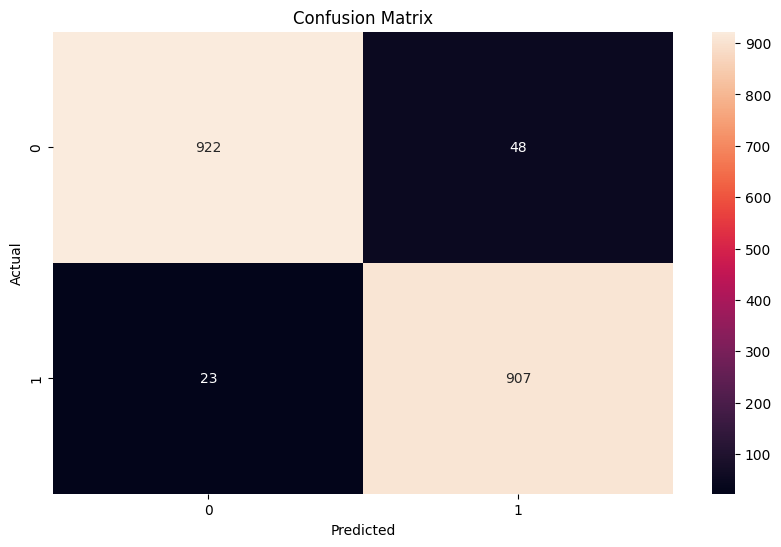

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
cm = confusion_matrix(y_pred[0], y)
#cm # X-axis Predicted vs Y-axis Actual Values
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()




In [60]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred[0]))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       945
           1       0.98      0.95      0.96       955

    accuracy                           0.96      1900
   macro avg       0.96      0.96      0.96      1900
weighted avg       0.96      0.96      0.96      1900



## Conclusions
The above seq. model performs well on a given task. 
Possible improvements:

    1. Inference Interface 
    2. Reducing the variance of text sequence lengths. (Texts in the dataset vary in length, balancing it may improve performance)
    3. Hyperparametrization fine-tuning
    4. Using pre-trained word-vectors like W2V, FastText etc.
    5. Using attention models.

(Improvements 4, and 5 would be good if decide to make our model more complex, include more authors for example. Otherwise seems excessive for this task)
